In [1]:
import os
import geopandas as gpd
import pandas as pd
import requests
import matplotlib.pyplot as plt
from shapely.geometry import shape

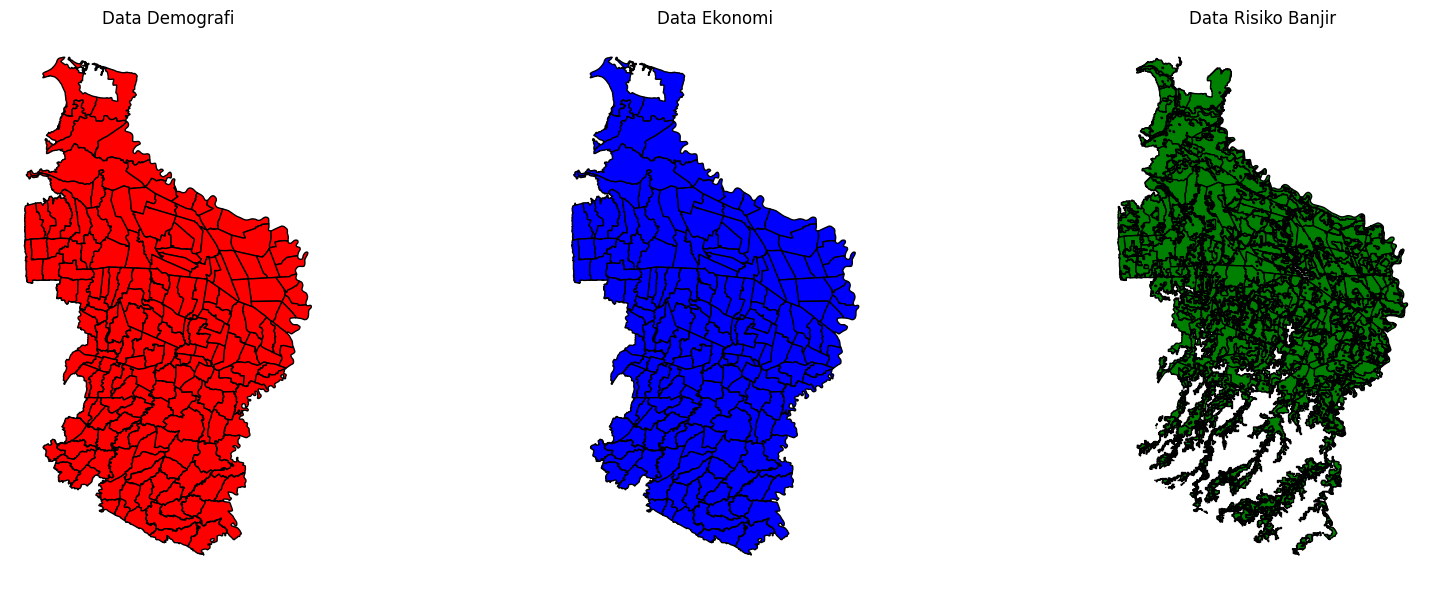

In [2]:
#Get API
urls = {"Demografi":"https://geoserver.mapid.io/layers_new/get_layer?api_key=5249521c14de436ebcf1fb8f05e6048d&layer_id=68aad862b2fcc5561a2df50f&project_id=68aad829b2025715f5988419&limit=10000",
        "Ekonomi" : "https://geoserver.mapid.io/layers_new/get_layer?api_key=5249521c14de436ebcf1fb8f05e6048d&layer_id=68ad623cb2fcc5561a30c8e6&project_id=68aad829b2025715f5988419&limit=10000",
        "Risiko Banjir":"https://geoserver.mapid.io/layers_new/get_layer?api_key=5249521c14de436ebcf1fb8f05e6048d&layer_id=68aad845b2fcc5561a2de721&project_id=68aad829b2025715f5988419&limit=10000",}


#Fungsi untuk menambahkan data dan menambahkan kolom skor
def get_data(url, layer_name):
    response = requests.get(url)
    if response.status_code == 200:
        geojson_data = response.json()
        gdf = gpd.GeoDataFrame.from_features(geojson_data['features'])

        # Pastikan kolom ada sebelum diakses
        if layer_name == "Demografi" and "JUMLAH PENDUDUK" in gdf.columns:
            gdf["SKOR_DEMOGRAFI"] = pd.qcut(
        gdf["JUMLAH PENDUDUK"], q=3, labels=[1, 2, 3]).astype(int)
        elif layer_name == "Ekonomi" and "SOCIOECONOMIC STATUS" in gdf.columns:
            gdf["SKOR_EKONOMI"] = (
                gdf["SOCIOECONOMIC STATUS"].astype(str).str.upper()
                .map({"ATAS": 1, "MENENGAH ATAS": 2, "MENENGAH": 3, "MENENGAH BAWAH":4})
                .fillna(0)
            )
        elif layer_name == "Risiko Banjir" and "KELAS_RISIKO" in gdf.columns:
            gdf["SKOR_BANJIR"] = (
                gdf["KELAS_RISIKO"].astype(str).str.upper()
                .map({"RENDAH": 1, "SEDANG": 2, "TINGGI": 3})
                .fillna(0)
            )
        return gdf
    return gpd.GeoDataFrame()


#Ambil data untuk semua layer 
gdf_demografi = get_data(urls["Demografi"],"Demografi")
gdf_ekonomi = get_data(urls["Ekonomi"],"Ekonomi")
gdf_banjir = get_data(urls["Risiko Banjir"],"Risiko Banjir")

# Visualisasi data menggunakan matplotlib
def visualize_data(gdfs):
    fig, axes = plt.subplots(1, len(gdfs), figsize=(18, 6))
    color_map = ['red', 'blue', 'green']  # Warna berbeda untuk setiap layer
    for ax, (name, gdf), color in zip(axes, gdfs.items(), color_map):
        gdf.plot(ax=ax, color=color, edgecolor='black')
        ax.set_title(name)
        ax.set_axis_off()
    plt.tight_layout()
    plt.show()

#Menampilkan Visualisasi data dari ketiga GeoDataFrame
visualize_data({"Data Demografi": gdf_demografi, "Data Ekonomi":
gdf_ekonomi, "Data Risiko Banjir": gdf_banjir})



  


In [3]:
#Mengatasi Nilai Null
#Periksa dan perbaiki nilai NULL sebelum intersect
gdf_demografi['SKOR_DEMOGRAFI'] = gdf_demografi['SKOR_DEMOGRAFI'].fillna(0)
gdf_ekonomi['SKOR_EKONOMI'] = gdf_ekonomi['SKOR_EKONOMI'].fillna(0)
gdf_banjir['SKOR_BANJIR'] = gdf_banjir['SKOR_BANJIR'].fillna(0)

print("Demografi CRS:", gdf_demografi.crs)
print("Ekonomi CRS:", gdf_ekonomi.crs)
print("Banjir CRS:", gdf_banjir.crs)

# Set CRS awal (WGS84) ke semua gdf
gdf_demografi = gdf_demografi.set_crs("EPSG:4326")
gdf_ekonomi   = gdf_ekonomi.set_crs("EPSG:4326")
gdf_banjir    = gdf_banjir.set_crs("EPSG:4326")

target_crs = gdf_demografi.crs
gdf_ekonomi = gdf_ekonomi.to_crs(target_crs)
gdf_banjir  = gdf_banjir.to_crs(target_crs)

#Validasi geometri
gdf_demografi["geometry"] = gdf_demografi["geometry"].buffer(0)
gdf_ekonomi["geometry"]   = gdf_ekonomi["geometry"].buffer(0)
gdf_banjir["geometry"]    = gdf_banjir["geometry"].buffer(0)

#filter hanya polygon/multipolygon
gdf_demografi = gdf_demografi[gdf_demografi.geometry.type.isin(["Polygon","MultiPolygon"])]
gdf_ekonomi   = gdf_ekonomi[gdf_ekonomi.geometry.type.isin(["Polygon","MultiPolygon"])]
gdf_banjir    = gdf_banjir[gdf_banjir.geometry.type.isin(["Polygon","MultiPolygon"])]

#overlay
intersection_gdf = gdf_demografi.copy()

if not gdf_ekonomi.empty:
    intersection_gdf = gpd.overlay(intersection_gdf, gdf_ekonomi, how="intersection")

if not gdf_banjir.empty:
    intersection_gdf = gpd.overlay(intersection_gdf, gdf_banjir, how="intersection")

#memperbaiki geometri yang tidak valid setelah intersection
intersection_gdf = intersection_gdf[intersection_gdf.is_valid]
intersection_gdf['geometry'] = intersection_gdf['geometry'].apply(lambda x:
x.make_valid() if not x.is_valid else x)

#Memperbaiki nilai NULL setelah intersection
intersection_gdf['SKOR_DEMOGRAFI'] =intersection_gdf['SKOR_DEMOGRAFI'].fillna(0)
intersection_gdf['SKOR_EKONOMI'] = intersection_gdf['SKOR_EKONOMI'].fillna(0)
intersection_gdf['SKOR_BANJIR'] = intersection_gdf['SKOR_BANJIR'].fillna(0)

#Hitung ulang skor total
intersection_gdf['SKOR_TOTAL'] = intersection_gdf['SKOR_DEMOGRAFI'] + intersection_gdf['SKOR_EKONOMI'] + intersection_gdf['SKOR_BANJIR']

#Klasifikasi
intersection_gdf['KESESUAIAN'] = pd.cut(
    intersection_gdf['SKOR_TOTAL'],
    bins=[2,5,7,9],
    labels=['RENDAH','SEDANG','TINGGI'],
    include_lowest=True)

print(intersection_gdf[['SKOR_DEMOGRAFI','SKOR_EKONOMI','SKOR_BANJIR','SKOR_TOTAL','KESESUAIAN']].head(10))





Demografi CRS: None
Ekonomi CRS: None
Banjir CRS: None


c:\BOOTCAMP\DAY_6\TASK_6\Lib\site-packages\geopandas\tools\overlay.py:358: UserWarning: `keep_geom_type=True` in overlay resulted in 1024 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  result = _collection_extract(result, geom_type, keep_geom_type_warning)
c:\BOOTCAMP\DAY_6\TASK_6\Lib\site-packages\geopandas\tools\overlay.py:358: UserWarning: `keep_geom_type=True` in overlay resulted in 2506 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  result = _collection_extract(result, geom_type, keep_geom_type_warning)


   SKOR_DEMOGRAFI  SKOR_EKONOMI  SKOR_BANJIR  SKOR_TOTAL KESESUAIAN
0               1             2            3           6     SEDANG
1               1             2            1           4     RENDAH
2               1             2            1           4     RENDAH
3               1             2            1           4     RENDAH
4               1             2            2           5     RENDAH
5               1             2            2           5     RENDAH
6               1             2            2           5     RENDAH
7               1             2            3           6     SEDANG
8               1             2            3           6     SEDANG
9               1             2            2           5     RENDAH


In [ ]:
#Simpan semua hasil ke GeoJSON
import os

output_dir = r"D:\BOOTCAMP MAPID\TASK 6"
os.makedirs(output_dir, exist_ok=True)

#Filter hanya geometri Polygon dan MultiPolygon
intersection_gdf_polygons = intersection_gdf[intersection_gdf.geometry.type.isin(['Polygon',
'MultiPolygon'])]

# Perbaiki geometri yang tidak valid
intersection_gdf['geometry'] = intersection_gdf_polygons['geometry'].apply(lambda x: x.make_valid() if not
x.is_valid else x)

# Simpan Data Variabel
gdf_demografi.to_file(os.path.join(output_dir, "demografi.geojson"),driver='GeoJSON')
gdf_ekonomi.to_file(os.path.join(output_dir,"ekonomi"),driver='GeoJSON')
gdf_banjir.to_file(os.path.join(output_dir, "risiko_banjir.geojson"),driver='GeoJSON')

#simpan hasil intersection yang telah diperbaiki ke GeoJSON
intersection_gdf_polygons.to_file(os.path.join(output_dir,"Hasil_Intersection.geojson"),driver='GeoJSON')

print(f"Data berhasil disimpan di :{output_dir}")
print("Semua file geojson terlah berhasil disimpan.")



Data berhasil disimpan di :D:\BOOTCAMP MAPID\TASK 6
Semua file geojson terlah berhasil disimpan.


In [ ]:
#Link Url Up di Geomapid
"Demografi" : "https://geoserver.mapid.io/layers_new/get_layer?api_key=5249521c14de436ebcf1fb8f05e6048d&layer_id=68ad73cbbdbfd0f39bfdbf2b&project_id=68ad73214a3bb7db313284b2"
"Ekonomi" : "https://geoserver.mapid.io/layers_new/get_layer?api_key=5249521c14de436ebcf1fb8f05e6048d&layer_id=68ad73a1278efb8118392303&project_id=68ad73214a3bb7db313284b2"
"Risiko Banjir": "https://geoserver.mapid.io/layers_new/get_layer?api_key=5249521c14de436ebcf1fb8f05e6048d&layer_id=68ad7334278efb811839206f&project_id=68ad73214a3bb7db313284b2"
"Hasil Intersection" :"https://geoserver.mapid.io/layers_new/get_layer?api_key=5249521c14de436ebcf1fb8f05e6048d&layer_id=68aeabc64a3bb7db3134ba79&project_id=68ad73214a3bb7db313284b2"